这个是深度学习课后的小作业，主要是给大家再熟悉一下模型训练的流程，让大家体验一下。我们这里的任务是对10个类别的“时装”图像进行分类，使用[FashionMNIST数据集](https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion )。 
FashionMNIST数据集中包含已经预先划分好的训练集和测试集，其中训练集共60,000张图像，测试集共10,000张图像。每张图像均为单通道黑白图像，大小为28\*28pixel，分属10个类别。  

**首先导入必要的包** 

In [132]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

**配置训练环境和超参数** 

In [133]:
# 配置GPU，这里有两种方式
## 方案一：使用os.environ
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256
num_workers = 0   # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 20

**数据读入和加载**  
这里同时展示两种方式:  
- 下载并使用PyTorch提供的内置数据集  
- 从网站下载以csv格式存储的数据，读入并转成预期的格式    
第一种数据读入方式只适用于常见的数据集，如MNIST，CIFAR10等，PyTorch官方提供了数据下载。这种方式往往适用于快速测试方法（比如测试下某个idea在MNIST数据集上是否有效）  
第二种数据读入方式需要自己构建Dataset，这对于PyTorch应用于自己的工作中十分重要  
  
同时，还需要对数据进行必要的变换，比如说需要将图片统一为一致的大小，以便后续能够输入网络训练；需要将数据格式转为Tensor类，等等。
  
**我们实际比赛的时候数据加载和处理是一个非常关键的步骤。**

In [134]:
# 首先设置数据变换
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
    transforms.ToPILImage(),  
     # 这一步取决于后续的数据读取方式，如果使用内置数据集读取方式则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [135]:
# ## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
# from torchvision import datasets

# train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)
# test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)

In [136]:
## 读取方式二：读入csv格式的数据，自行构建Dataset类
# csv数据下载链接：https://www.kaggle.com/zalando-research/fashionmnist
class FMDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.images = df.iloc[:,1:].values.astype(np.uint8)
        self.labels = df.iloc[:, 0].values
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28,28,1)
        label = int(self.labels[idx])
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(image/255., dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

train_df = pd.read_csv("./FashionMNIST/fashion-mnist_train.csv")
test_df = pd.read_csv("./FashionMNIST/fashion-mnist_test.csv")
train_data = FMDataset(train_df, data_transform)
test_data = FMDataset(test_df, data_transform)

在构建训练和测试数据集完成后，需要定义DataLoader类，以便在训练和测试时加载数据  

In [137]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

读入后，我们可以做一些数据可视化操作，主要是验证我们读入的数据是否正确

torch.Size([256, 1, 28, 28]) torch.Size([256])


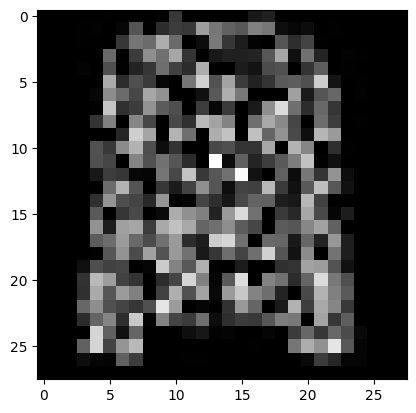

In [138]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

**模型设计**  
由于任务较为简单，这里我们手搭一个CNN，而不考虑当下各种模型的复杂结构，模型构建完成后，将模型放到GPU上用于训练。  

In [139]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

model = Net()
model = model.cuda()
# model = nn.DataParallel(model).cuda()   # 多卡训练时的写法

**设定损失函数**  
使用torch.nn模块自带的CrossEntropy损失  
PyTorch会自动把整数型的label转为one-hot型，用于计算CE loss  
这里需要确保label是从0开始的，同时模型不加softmax层（使用logits计算）,这也说明了PyTorch训练中各个部分不是独立的，需要通盘考虑

In [140]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=[1,1,1,1,3,1,1,1,1,1])

**设定优化器**  
这里我们使用Adam优化器 

In [141]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

**训练流程（自己写）**
调⽤model.train()
(1) 从train_dataloader中加载数据
(2) 计算损失函数
(3) 反向传播，优化器优化
(4) print展⽰输出

In [142]:
def train(epoch):
    total_train_step = 0
    for i in range(epoch):
        total_test_loss = 0
        total_acc_sum = 0
        print("-----------------第{}轮训练开始--------------------".format(i+1))
        model.train()
        for data in train_loader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item()
            acc_sum = (outputs.argmax(1) == targets).sum().item()
            total_acc_sum += acc_sum

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_step = total_train_step + 1
            if total_train_step % 100 == 0:
                print("训练次数: {}, Loss: {}".format(total_train_step, loss.item()))
        print("整体训练上的loss: {}".format(total_test_loss))
        print("整体训练上的acc: {}".format(total_acc_sum / (train_data.__len__() )))

    return 

**验证流程（自己写）**
关注两者的主要区别：  
- 模型状态设置  
- 是否需要初始化优化器
- 是否需要将loss传回到网络
- 是否需要每步更新optimizer  
  
此外，对于测试或验证过程，可以计算分类准确率，要求把结果print出来

In [143]:
def test(epoch):
    model.eval()
    total_test_step = 0
    total_test_loss = 0
    total_acc_sum = 0
    with torch.no_grad():
        for data in test_loader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            total_test_loss = total_test_loss + loss.item()
            acc_sum = (outputs.argmax(1) == targets).sum().item()
            total_acc_sum = total_acc_sum + acc_sum

    print ("整体测试数据集上的Loss: {}".format(total_test_loss))
    print ("整体测试数据集上的acc: {}".format(total_acc_sum / (test_data.__len__() )))
    total_test_step = total_test_step + 1
    return

In [144]:
# epoch 自己设定值，这里要求设定成一个列表，看看不同epoch对结果的影响
for epoch in range(1, epochs+1):
    train(epoch)
    test(epoch)

-----------------第1轮训练开始--------------------
训练次数: 100, Loss: 0.5487737059593201
训练次数: 200, Loss: 0.49675455689430237
整体训练上的loss: 159.23691868782043
整体训练上的acc: 0.7446833333333334
整体测试数据集上的Loss: 18.003009647130966
整体测试数据集上的acc: 0.8376
-----------------第1轮训练开始--------------------
训练次数: 100, Loss: 0.46815672516822815
训练次数: 200, Loss: 0.3526226878166199
整体训练上的loss: 102.30776056647301
整体训练上的acc: 0.8382333333333334
-----------------第2轮训练开始--------------------
训练次数: 300, Loss: 0.38241490721702576
训练次数: 400, Loss: 0.33788856863975525
整体训练上的loss: 85.49100184440613
整体训练上的acc: 0.8636333333333334
整体测试数据集上的Loss: 12.423908069729805
整体测试数据集上的acc: 0.8892
-----------------第1轮训练开始--------------------
训练次数: 100, Loss: 0.2564340829849243
训练次数: 200, Loss: 0.34448137879371643
整体训练上的loss: 77.64192074537277
整体训练上的acc: 0.8775166666666666
-----------------第2轮训练开始--------------------
训练次数: 300, Loss: 0.31526708602905273
训练次数: 400, Loss: 0.29326409101486206
整体训练上的loss: 71.2707199305296
整体训练上的acc: 0.88725
--------

In [145]:
save_path = "./FahionModel.pkl"
torch.save(model, save_path)